# Progetto CV

In [5]:
import cv2
from matplotlib import pyplot as plt

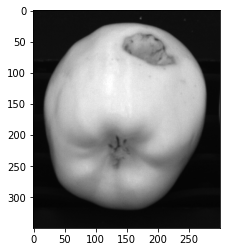

In [29]:
img = cv2.imread("img/first task/C0_000002.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

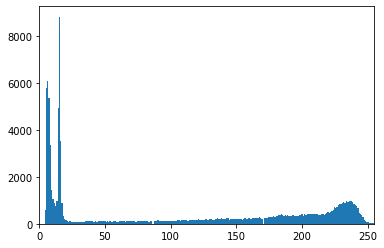

In [30]:
# calculate mean value from RGB channels and flatten to 1D array
vals = img.flatten()
# plot histogram with 255 bins
b, bins, patches = plt.hist(vals, 255)
plt.xlim([0,255])
plt.show()

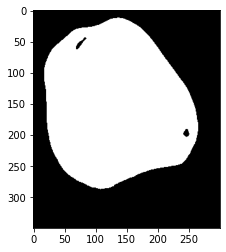

In [31]:
blur = cv2.GaussianBlur(img,(5,5),0)
ret,th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th, cmap='gray', vmin=0, vmax=255)
plt.show()